Studying the effect of asymmetrical variability on back propagation
# Loading the libraries

In [32]:
import numpy as np
import time
import pandas as pd
from sklearn.datasets import fetch_openml
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from numba import njit, cuda
import matplotlib

# Preparing the dataset

In [2]:
#fetch the mnist dataset
x, y = fetch_openml('Fashion-MNIST', version=1, return_X_y=True, as_frame=False)
#x, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
print(x.shape,y.shape)

(70000, 784) (70000,)


In [3]:
#x_n = x.to_numpy()
x_n = x
#y_n = y.to_numpy()
y_n = y

In [4]:
y_n = y_n.astype('int') #convert output to integers 0-9
x_norm = x_n/255.0 #normalise input data
x_train, x_val, y_train, y_val = train_test_split(x_norm, y_n, test_size=0.1, random_state=42) #split the data into train and validation
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

x_train = x_train.T #take the transpose of the training data m*784 -> 784*m
x_val = x_val.T #take the transpose of the test data m*784 -> 784*m
print(x_train.shape, x_val.shape)

(63000, 784) (7000, 784) (63000,) (7000,)
(784, 63000) (784, 7000)


In [5]:
x_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Training software BP with new subsampled version of MNIST

In [6]:
def params_init(newShape, midLayerSize, seed=2):

  np.random.seed(seed)
  W1 = np.random.rand(midLayerSize,newShape) - 0.5
  b1 = np.random.rand(midLayerSize,1) - 0.5
  W2 = np.random.rand(10,midLayerSize) - 0.5 
  b2 = np.random.rand(10,1) - 0.5 
  print("Params Initialised")

  return (W1, b1, W2, b2)

In [7]:

def predictions(A):
  #argmax returns the index of maximum value, we will feed the sigmoid output to this function 
  return np.argmax(A,0)


def accuracy(A,Y):
  #this will compare the predicted output to the ground truth
  return np.sum(A == Y)/(Y.shape[0])*100

In [8]:
def relu(x):
   return np.maximum(x,0)


def softmax(Z):
  return np.exp(Z) / np.sum(np.exp(Z),0)
  #Z = Z-np.max(Z, axis=0)
  #return np.exp(Z) / np.sum(np.exp(Z),0)


def relu_d(x):
  return x>0

def one_hot_encoding(y):
  shape = (y.shape[0], 10)
  one_hot = np.zeros(shape)
  rows = np.arange(y.size)
  one_hot[rows, y] = 1
  return one_hot.T

def crossEntropy(y,y_pre):
  loss=-np.sum(np.multiply(y, np.log(y_pre + 10e-16)), axis = 0)
  return loss

In [9]:
def forward(x_train, W1, b1, W2, b2):
  #print("Entered FP")
  Z1 = np.matmul(W1,x_train) + b1 #W1 is 50*784, x_train is 748*m, Z1 is 50*m
  A1 = relu(Z1)

  Z2 = np.matmul(W2,A1) + b2
  A2 = softmax(Z2)
  

  return Z1, A1, Z2, A2

In [10]:
def param_update(W1, b1, W2, b2, dW1, db1, dW2, db2, lr):

  #updates the parameters based on backpropogation

  W1 = W1 - lr*dW1
  b1 = b1 - lr*(db1.reshape(b1.shape))
  W2 = W2 - lr*dW2
  b2 = b2 - lr*(db2.reshape(b2.shape))


  return W1, b1, W2, b2

In [11]:
def backprop(Z1, A1, Z2, A2, W1, W2, X, y):
  m = y.shape[0] #m is the number of training examples
  Y = one_hot_encoding(y)

  dZ2 = (A2 - Y)
  
  dW2 = 1/m*np.matmul(dZ2,A1.T)

  db2 = 1/m*np.sum(dZ2, axis=1)

  dZ1 = np.matmul(W2.T, dZ2)*relu_d(Z1) #W2 is 10*50, dZ2 = 10*m, dZ1 = 50*m

  dW1 = 1/m*np.matmul(dZ1,X.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db1 = 1/m*np.sum(dZ1, axis=1) #db1 is 50*1


  return dW1, db1, dW2, db2

In [12]:
def batch_grad_descent(X,Y,batchsize,iter, lr, midLayerSize, seed = None, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []

  weightsDict = {}
  newShape = X[:, 0].shape[0]
  W1, b1, W2, b2 = params_init(newShape=newShape, midLayerSize = midLayerSize, seed = seed)
  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0




    for j in range(63000//batchsize): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*batchsize: (j+1)*batchsize].T,Y[j*batchsize: (j+1)*batchsize]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes
      #X1, Y1 = X, Y

      Z1, A1, Z2, A2 = forward(X1, W1, b1, W2, b2) 

      dW1, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1, W2, X1, Y1)


      W1, b1, W2, b2 = param_update(W1, b1, W2, b2,  dW1, db1, dW2, db2,  lr = lr)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _,  A2_train = forward(X, W1, b1, W2, b2)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A2_train), Y)
      train_acc.append(train_score)
      train_loss.append(np.sum(crossEntropy(one_hot_encoding(Y), A2_train)))
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _,   A2_val = forward(x_val, W1, b1, W2, b2)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A2_val), y_val)
      val_acc.append(val_score)
      val_loss.append(np.sum(crossEntropy(one_hot_encoding(y_val), A2_val)))
      print(f'Val accuracy: {val_score} Val loss: {np.sum(crossEntropy(one_hot_encoding(y_val), A2_val))}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')
      # plt.figure()
      # plt.hist(W1.flatten())

  return W1, b1, W2, b2, train_acc, val_acc, train_loss, val_loss, sum_weights


In [13]:
W1, b1, W2, b2, train_accBP, val_accBP, train_loss, val_loss, sum_weights = batch_grad_descent(x_train,y_train,batchsize = 630,iter=100, lr=0.1,midLayerSize = 10, seed = 47,print_op=1);

Params Initialised
Iteration: 1
Train accuracy: 65.67142857142856
Val accuracy: 64.47142857142858 Val loss: 6653.281599688319
Iteration: 2
Train accuracy: 69.95396825396826
Val accuracy: 69.19999999999999 Val loss: 5723.207730349599
Iteration: 3
Train accuracy: 71.65079365079366
Val accuracy: 71.14285714285714 Val loss: 5342.6829474595215
Iteration: 4
Train accuracy: 72.63809523809523
Val accuracy: 72.17142857142858 Val loss: 5110.70009579257
Iteration: 5
Train accuracy: 73.4904761904762
Val accuracy: 73.12857142857143 Val loss: 4928.86631570027
Iteration: 6
Train accuracy: 74.28095238095239
Val accuracy: 74.02857142857144 Val loss: 4764.495329503857
Iteration: 7
Train accuracy: 74.98412698412699
Val accuracy: 74.7 Val loss: 4633.007240898238
Iteration: 8
Train accuracy: 75.53650793650793
Val accuracy: 75.34285714285714 Val loss: 4518.873969677319
Iteration: 9
Train accuracy: 76.11904761904762
Val accuracy: 76.0 Val loss: 4412.086344467167
Iteration: 10
Train accuracy: 76.7
Val accurac

### Generic functions related to variability

In [14]:
#helps in rounding to the nearest integer multiples of the chosen 'step' value!
#add clipping here
# def roundArbitrary(weightArray, step):
#   weightArrayDiv = weightArray / step
#   weightArrayDiv = np.round(weightArrayDiv)
#   return weightArrayDiv*step
def roundArbitrary(weightArray, step, wRange):#updates function with clipping
    #wRange is added for the clipping component 

    weightArrayDiv = np.clip(weightArray, a_min = -wRange, a_max = wRange)
    weightArrayDiv = weightArrayDiv / step
    weightArrayDiv = np.round(weightArrayDiv)
    return weightArrayDiv*step

In [100]:
def initMosParam(shape, mu, sigma, vDD, precision, k=10000):
    #modelling both Ion and Ioff  = I0*exp(Vgs-Vth/(eta*kB*T)),
    dim1, dim2 = shape
    sizeI = (dim1, dim2, precision)
    I0On = 1e+06
    I0Off = I0On/k
    #eta = 
    #kB = 1.3806452e10-23
    #T = 300
    VT = 0.026*1.5#should be eqaul to eta x kB x T

    #Vth = getVth(mu, sigma, sizeI)#get the array of Vth values 
    Vth = np.random.normal(loc=mu, scale=sigma, size = sizeI)
    Vth[Vth<=0] = 10e-10

    #iOn = ((vDD - Vth)**2)*I0On#scaling the current according to Ioff values arbitraryfor now!!
    iOn = I0On * np.exp((0 - Vth)/(VT))
    #iOn = I0On * np.ones_like(Vth)



    #iOnNominal = 1e-06*(vDD**2 - (2*vDD*mu) + (sigma**2  + mu**2))
    iOnNominal = np.sum(iOn)/(dim1*dim2*precision)
    #Vth = np.random.normal(loc=mu, scale=sigma, size = sizeI)
    #iOff = np.random.uniform(low=0, high=1e-8, size = sizeI)#no negative value
    iOff = I0Off * np.exp((0 - Vth)/(VT))
    #iOff = I0Off * np.ones_like(Vth)
    #return these
    return (iOn, iOnNominal, iOff)

In [16]:
def weightTransformWithVariability(weightArray, currents, precision, step, discreteSteps, wRange):
  dim1, dim2 = weightArray.shape
  sizeI = (dim1, dim2, precision)

  #clippedWeightIndexArray = np.digitize(np.abs(weightArray), discreteSteps) #finds the index value of the weights
  #updating the above to the actual round function.
  clippedWeightIndexArray = (roundArbitrary(weightArray, step, wRange)/step).astype(np.int64)
  clippedWeightIndexArray = np.abs(clippedWeightIndexArray)

  #vDD = 5
  #mu = 0.7#mean of the distribution
  #sigma = 0.00001
  #! work with sigma/mu
  
  iOn, iOnNominal, iOff = currents

  
  analogWeightArray = np.zeros_like(weightArray, dtype=float)

  for bitLevel in range(precision):
    analogWeightArray +=  np.where(np.bitwise_and(clippedWeightIndexArray, 2**bitLevel)>=1, iOn[:, :, bitLevel], iOff[:, :, bitLevel]) * (2**bitLevel)

  
  analogWeightArray  = np.multiply(np.sign(weightArray), analogWeightArray)

  weightWithVariability = (analogWeightArray/iOnNominal)*step
  return weightWithVariability

In [73]:
W1, b1, W2, b2, train_accBP, val_accBP, train_loss, val_loss, sum_weights = batch_grad_descent(x_train,y_train,batchsize = 630,iter=100, lr=0.1,midLayerSize = 10, seed = 47,print_op=1);

Params Initialised
Iteration: 1
Train accuracy: 65.67142857142856
Val accuracy: 64.47142857142858 Val loss: 6653.281599688319
Iteration: 2
Train accuracy: 69.95396825396826
Val accuracy: 69.19999999999999 Val loss: 5723.207730349599
Iteration: 3
Train accuracy: 71.65079365079366
Val accuracy: 71.14285714285714 Val loss: 5342.6829474595215
Iteration: 4
Train accuracy: 72.63809523809523
Val accuracy: 72.17142857142858 Val loss: 5110.70009579257
Iteration: 5
Train accuracy: 73.4904761904762
Val accuracy: 73.12857142857143 Val loss: 4928.86631570027
Iteration: 6
Train accuracy: 74.28095238095239
Val accuracy: 74.02857142857144 Val loss: 4764.495329503857
Iteration: 7
Train accuracy: 74.98412698412699
Val accuracy: 74.7 Val loss: 4633.007240898238
Iteration: 8
Train accuracy: 75.53650793650793
Val accuracy: 75.34285714285714 Val loss: 4518.873969677319
Iteration: 9
Train accuracy: 76.11904761904762
Val accuracy: 76.0 Val loss: 4412.086344467167
Iteration: 10
Train accuracy: 76.7
Val accurac

In [104]:
mu = 0.7
sigma = 0.0000000001
onoff = 1000000000
asym = 1
vDD = 5
precision = 1#setting the precision value of the calculations
wRange = 1
noOfLevels = 2**precision - 1 #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  wRange/noOfLevels#step size of each of the step after quantization
#discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
discreteSteps = [step*i for i in range(0, noOfLevels)] #storing the values of the steps
iter = 100
midLayerSize = 10 #10
lr = 0.1 #0.1
batchsize = 630
newShape = x_train[:, 0].shape[0]

In [105]:
onlineTrainAcc = []
onlineValAcc= []
onlineTrainLoss = []
onlineValLoss = []
SigmaVal = 10**(-1*np.arange(1, 4, 0.1))
onOffRatio = [1, 10, 100, 1000, 10000, 100000]
precisionVal = [4, 6, 8, 10, 12, 14, 16]
for sigma in SigmaVal:
    W1Currents = initMosParam((midLayerSize, newShape), mu, sigma, vDD, precision, k =onoff)#k = Ion/Ioff
    b1Currents = initMosParam((midLayerSize, 1), mu, sigma, vDD, precision,k =onoff)
    W2Currents = initMosParam((10, midLayerSize) ,mu, sigma, vDD, precision,k =onoff)
    b2Currents = initMosParam((10, 1), mu, sigma, vDD, precision,k =onoff)
    W1varoc = weightTransformWithVariability(W1, W1Currents, precision, step, discreteSteps, wRange)
    b1varoc = weightTransformWithVariability(b1, b1Currents, precision, step, discreteSteps, wRange)
    W2varoc = weightTransformWithVariability(W2, W2Currents, precision, step, discreteSteps, wRange)
    b2varoc = weightTransformWithVariability(b2, b2Currents, precision, step, discreteSteps, wRange)
    _, _, _,  A2_train = forward(x_train, W1varoc, b1varoc, W2varoc, b2varoc)
    _, _, _,   A2_val = forward(x_val, W1varoc, b1varoc, W2varoc, b2varoc)
    onlineTrainAcc.append(accuracy(predictions(A2_train), y_train))
    onlineTrainLoss.append(np.sum(crossEntropy(one_hot_encoding(y_train), A2_train)))
    onlineValAcc.append(accuracy(predictions(A2_val), y_val))
    onlineValLoss.append(np.sum(crossEntropy(one_hot_encoding(y_val), A2_val)))


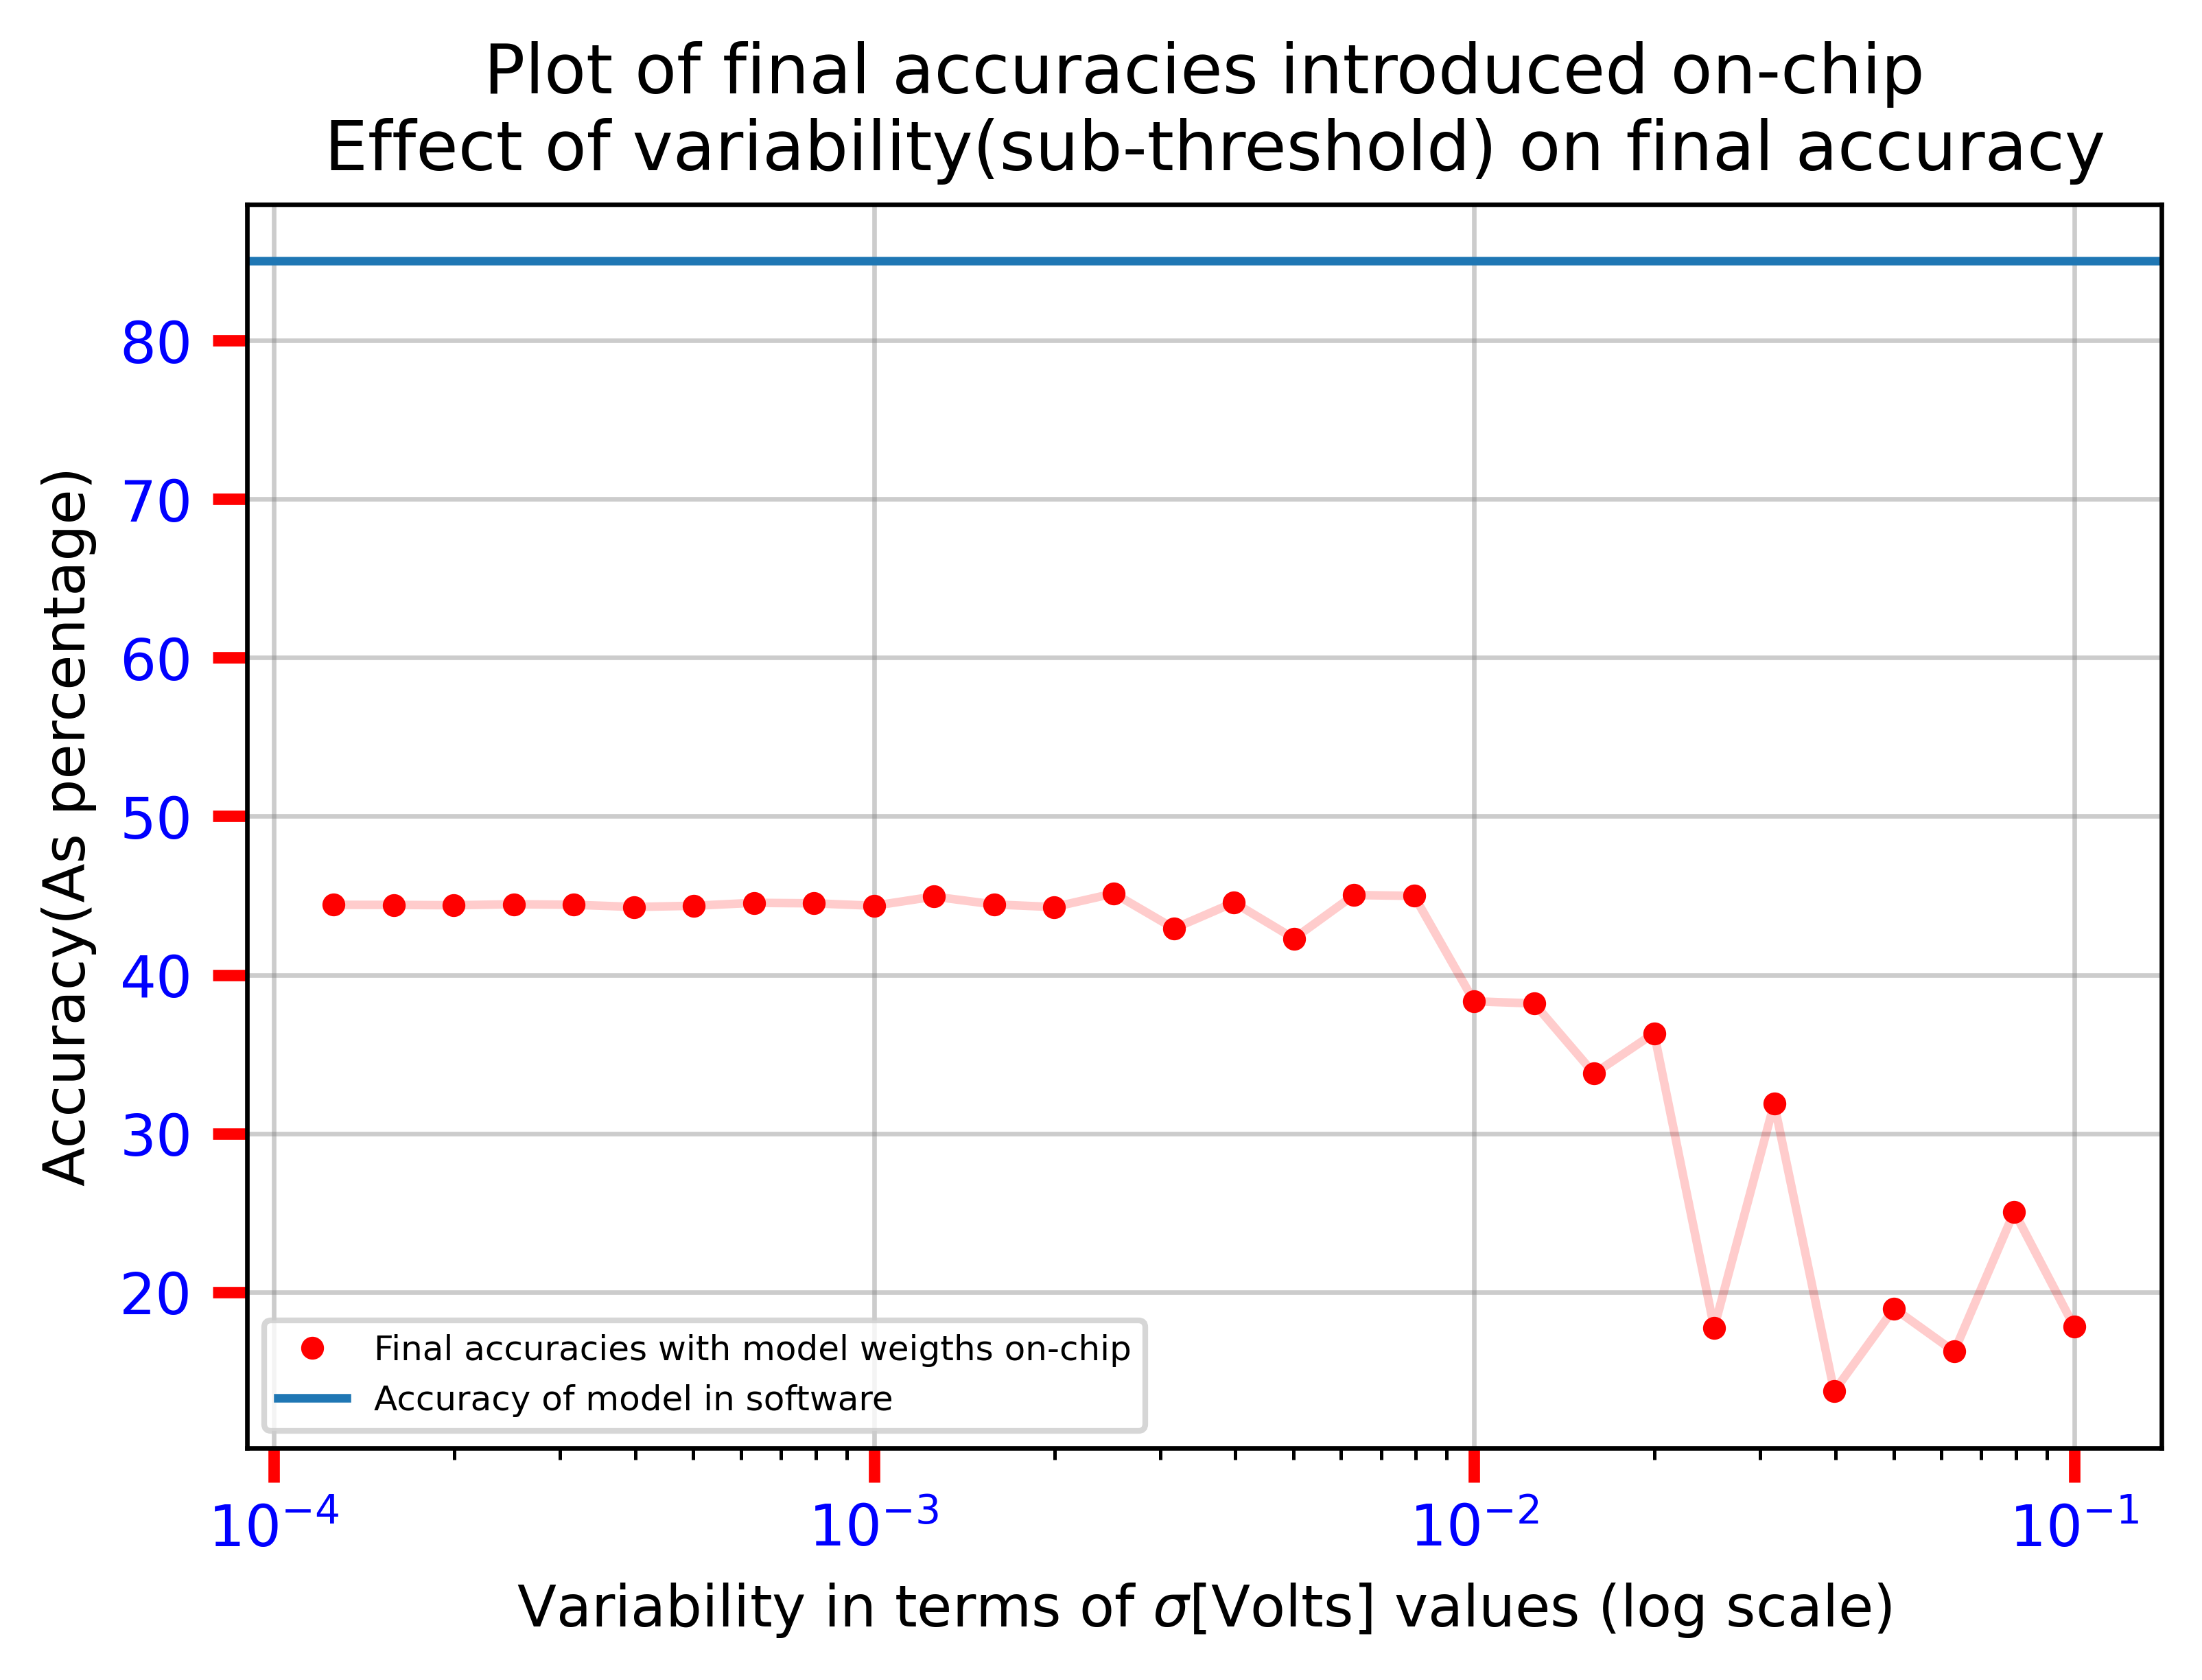

In [106]:
matplotlib.rcParams["figure.dpi"] = 600
plt.plot(SigmaVal, onlineTrainAcc, 'r.', label = "Final accuracies with model weigths on-chip")
plt.plot(SigmaVal, onlineTrainAcc, 'r', alpha = 0.2)
plt.axhline(train_accBP[-1], label = "Accuracy of model in software")
plt.xscale("log")
plt.tick_params(axis='both', direction='out', length=6, width=2, labelcolor='b', colors='r', grid_color='gray', grid_alpha=0.4)
plt.grid()
plt.xlabel(r"Variability in terms of $\sigma$[Volts] values (log scale)")
plt.ylabel("Accuracy(As percentage)")
plt.title("Plot of final accuracies introduced on-chip\n Effect of variability(sub-threshold) on final accuracy")
plt.legend(fontsize = 6)

In [94]:
mu = 0.7
sigma = 0.0000000001
onoff = 1000000000
asym = 1
vDD = 5
precision = 4#setting the precision value of the calculations
wRange = 1
noOfLevels = 2**precision - 1 #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  wRange/noOfLevels#step size of each of the step after quantization
#discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
discreteSteps = [step*i for i in range(0, noOfLevels)] #storing the values of the steps
iter = 100
midLayerSize = 10 #10
lr = 0.1 #0.1
batchsize = 630
newShape = x_train[:, 0].shape[0]

In [95]:
onlineTrainAcc = []
onlineValAcc= []
onlineTrainLoss = []
onlineValLoss = []
SigmaVal = 10**(-1*np.arange(1, 4, 0.1))
onOffRatio = 10**(np.arange(0, 4, 0.1))
precisionVal = [4, 6, 8, 10, 12, 14, 16]
for onoff in onOffRatio:
    W1Currents = initMosParam((midLayerSize, newShape), mu, sigma, vDD, precision, k =onoff)#k = Ion/Ioff
    b1Currents = initMosParam((midLayerSize, 1), mu, sigma, vDD, precision,k =onoff)
    W2Currents = initMosParam((10, midLayerSize) ,mu, sigma, vDD, precision,k =onoff)
    b2Currents = initMosParam((10, 1), mu, sigma, vDD, precision,k =onoff)
    W1varoc = weightTransformWithVariability(W1, W1Currents, precision, step, discreteSteps, wRange)
    b1varoc = weightTransformWithVariability(b1, b1Currents, precision, step, discreteSteps, wRange)
    W2varoc = weightTransformWithVariability(W2, W2Currents, precision, step, discreteSteps, wRange)
    b2varoc = weightTransformWithVariability(b2, b2Currents, precision, step, discreteSteps, wRange)
    _, _, _,  A2_train = forward(x_train, W1varoc, b1varoc, W2varoc, b2varoc)
    _, _, _,   A2_val = forward(x_val, W1varoc, b1varoc, W2varoc, b2varoc)
    onlineTrainAcc.append(accuracy(predictions(A2_train), y_train))
    onlineTrainLoss.append(np.sum(crossEntropy(one_hot_encoding(y_train), A2_train)))
    onlineValAcc.append(accuracy(predictions(A2_val), y_val))
    onlineValLoss.append(np.sum(crossEntropy(one_hot_encoding(y_val), A2_val)))


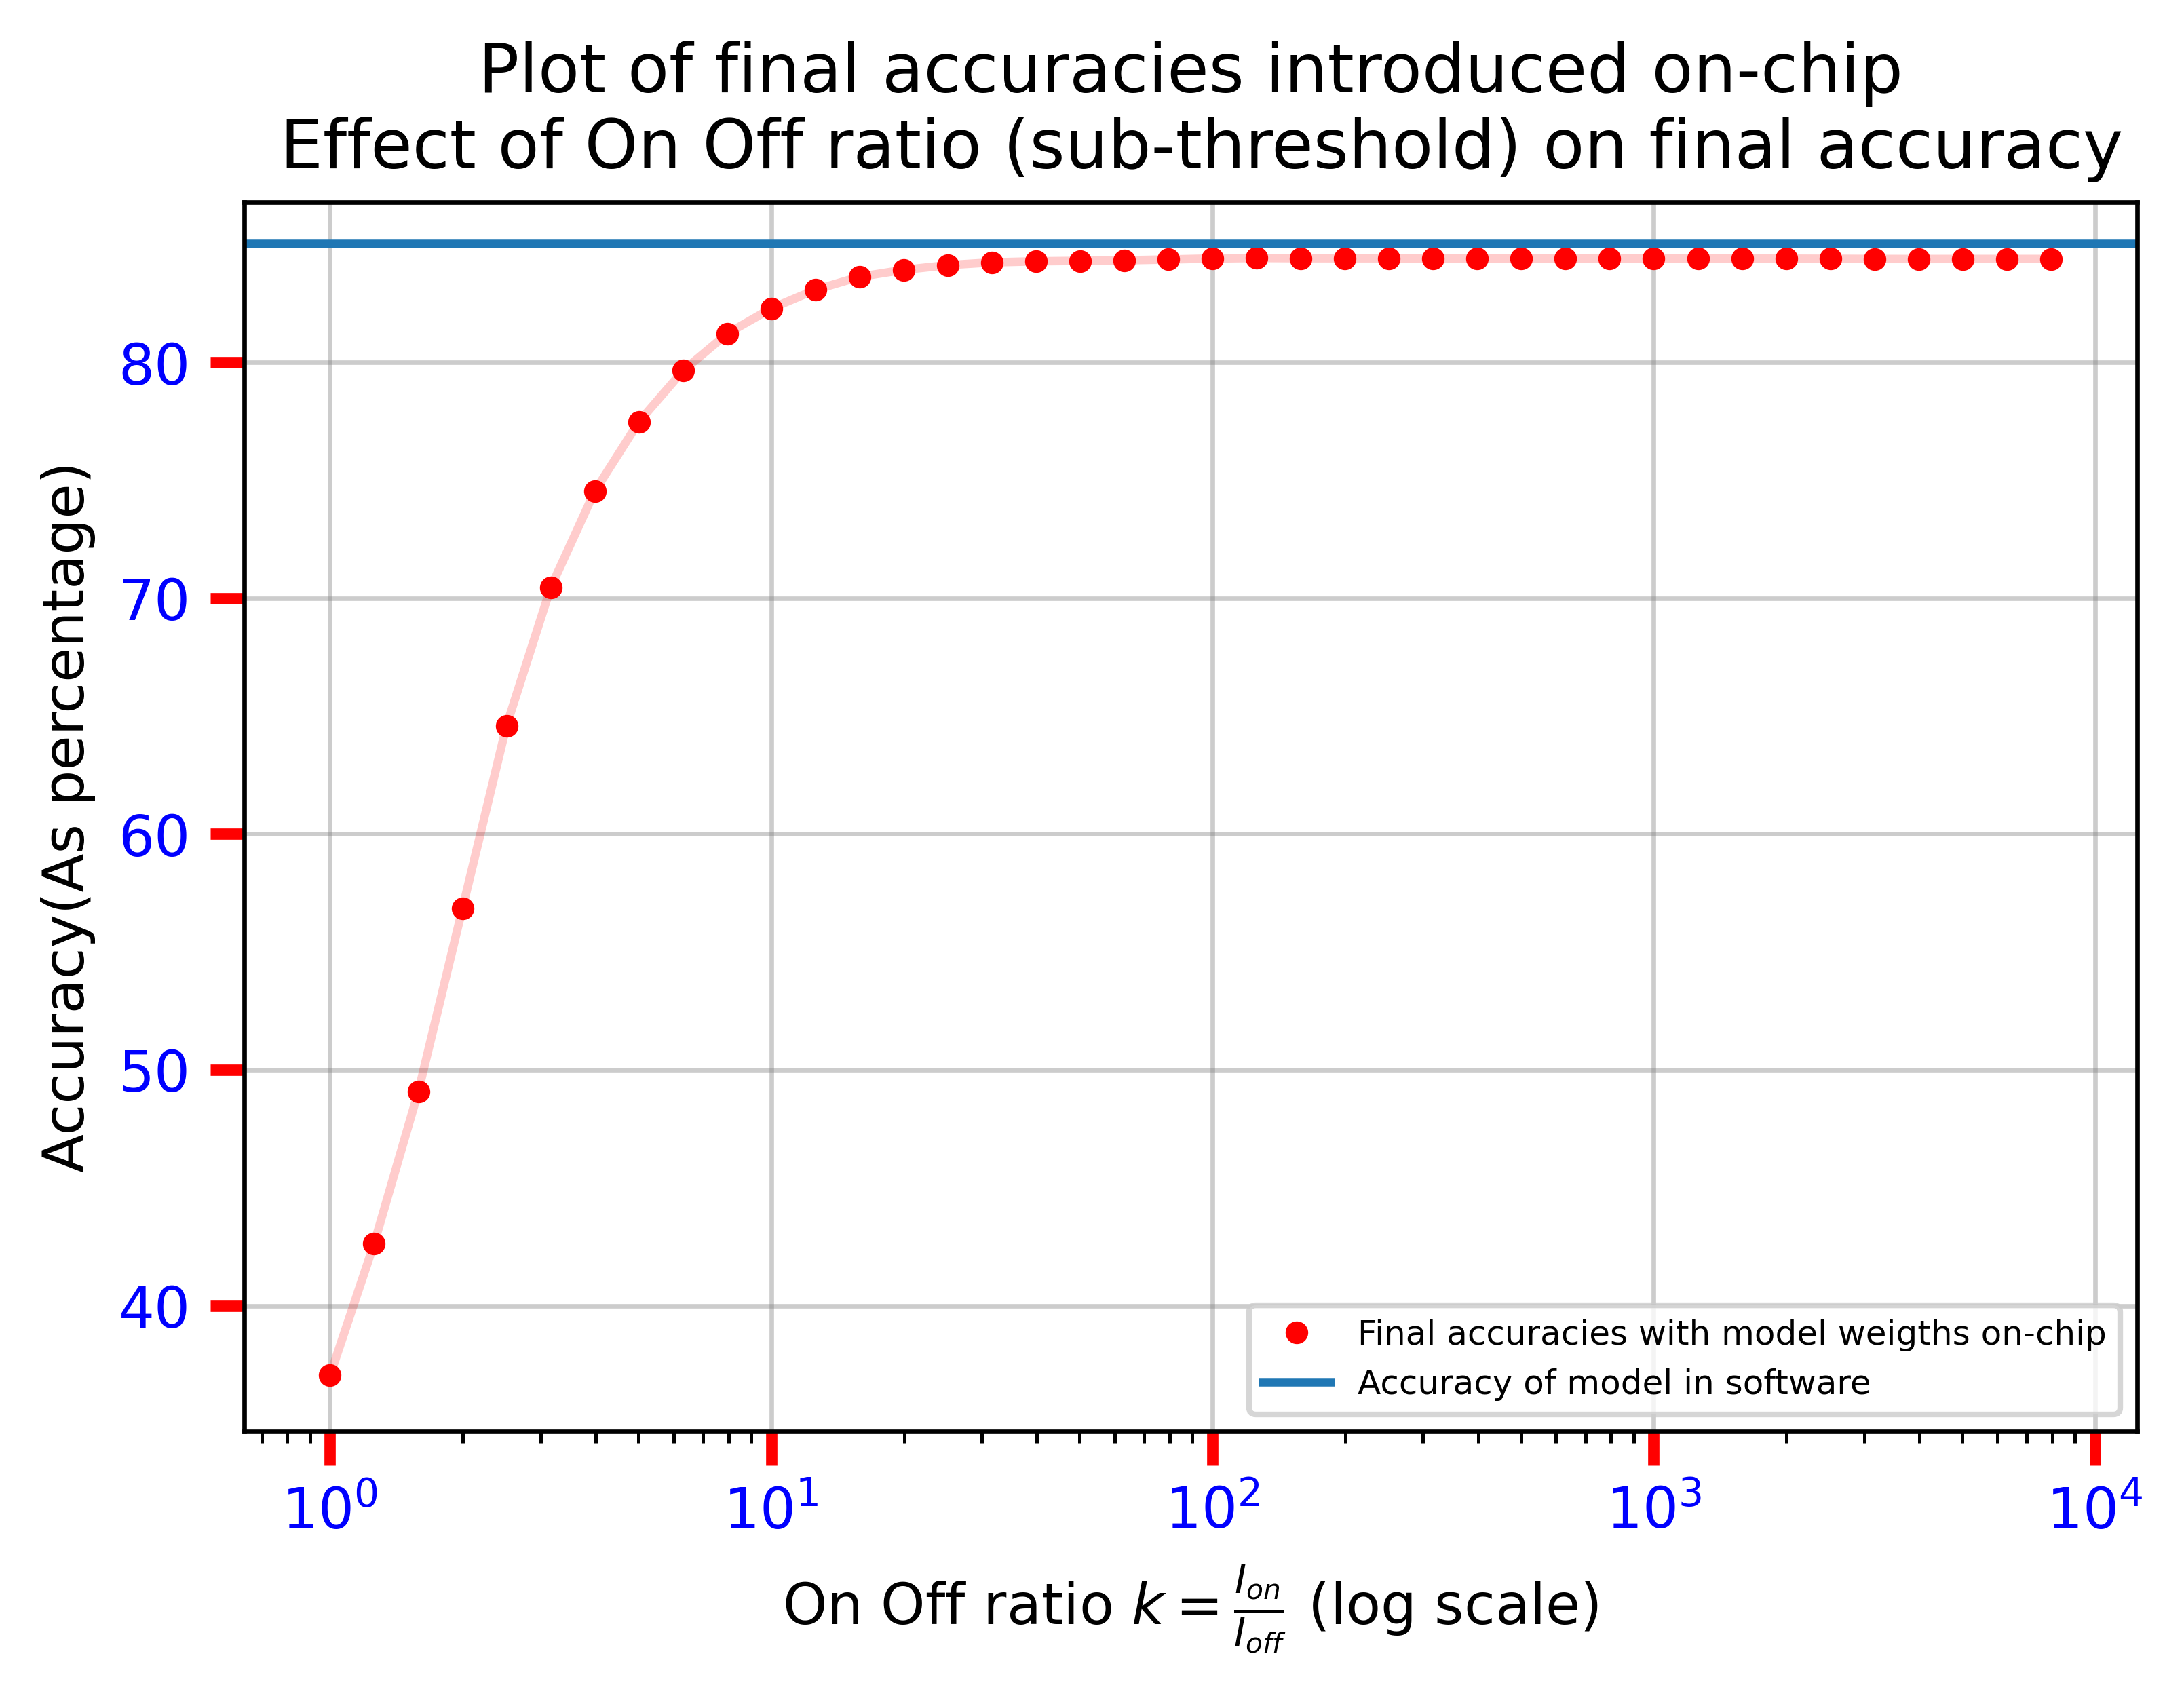

In [96]:
matplotlib.rcParams["figure.dpi"] = 600
plt.plot(onOffRatio, onlineTrainAcc, 'r.', label = "Final accuracies with model weigths on-chip")
plt.plot(onOffRatio, onlineTrainAcc, 'r', alpha = 0.2)
plt.axhline(train_accBP[-1], label = "Accuracy of model in software")
plt.xscale("log")
plt.tick_params(axis='both', direction='out', length=6, width=2, labelcolor='b', colors='r', grid_color='gray', grid_alpha=0.4)
plt.grid()
plt.xlabel(r"On Off ratio $k = \frac{I_{on}}{I_{off}}$ (log scale)")
plt.ylabel("Accuracy(As percentage)")
plt.title("Plot of final accuracies introduced on-chip\n Effect of On Off ratio (sub-threshold) on final accuracy")
plt.legend(fontsize = 6)

In [107]:
mu = 0.7
sigma = 0.0000000001
onoff = 1000000000
asym = 1
vDD = 5
precision = 4#setting the precision value of the calculations
wRange = 1
noOfLevels = 2**precision - 1 #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  wRange/noOfLevels#step size of each of the step after quantization
#discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
discreteSteps = [step*i for i in range(0, noOfLevels)] #storing the values of the steps
iter = 100
midLayerSize = 10 #10
lr = 0.1 #0.1
batchsize = 630
newShape = x_train[:, 0].shape[0]

In [110]:
onlineTrainAcc = []
onlineValAcc= []
onlineTrainLoss = []
onlineValLoss = []
SigmaVal = 10**(-1*np.arange(1, 4, 0.1))
onOffRatio = 10**(np.arange(1, 6, 0.1))
precisionVal = [2, 4, 6, 8, 10, 12, 14, 16]
for precision in precisionVal:
    W1Currents = initMosParam((midLayerSize, newShape), mu, sigma, vDD, precision, k =onoff)#k = Ion/Ioff
    b1Currents = initMosParam((midLayerSize, 1), mu, sigma, vDD, precision,k =onoff)
    W2Currents = initMosParam((10, midLayerSize) ,mu, sigma, vDD, precision,k =onoff)
    b2Currents = initMosParam((10, 1), mu, sigma, vDD, precision,k =onoff)
    W1varoc = weightTransformWithVariability(W1, W1Currents, precision, step, discreteSteps, wRange)
    b1varoc = weightTransformWithVariability(b1, b1Currents, precision, step, discreteSteps, wRange)
    W2varoc = weightTransformWithVariability(W2, W2Currents, precision, step, discreteSteps, wRange)
    b2varoc = weightTransformWithVariability(b2, b2Currents, precision, step, discreteSteps, wRange)
    _, _, _,  A2_train = forward(x_train, W1varoc, b1varoc, W2varoc, b2varoc)
    _, _, _,   A2_val = forward(x_val, W1varoc, b1varoc, W2varoc, b2varoc)
    onlineTrainAcc.append(accuracy(predictions(A2_train), y_train))
    onlineTrainLoss.append(np.sum(crossEntropy(one_hot_encoding(y_train), A2_train)))
    onlineValAcc.append(accuracy(predictions(A2_val), y_val))
    onlineValLoss.append(np.sum(crossEntropy(one_hot_encoding(y_val), A2_val)))


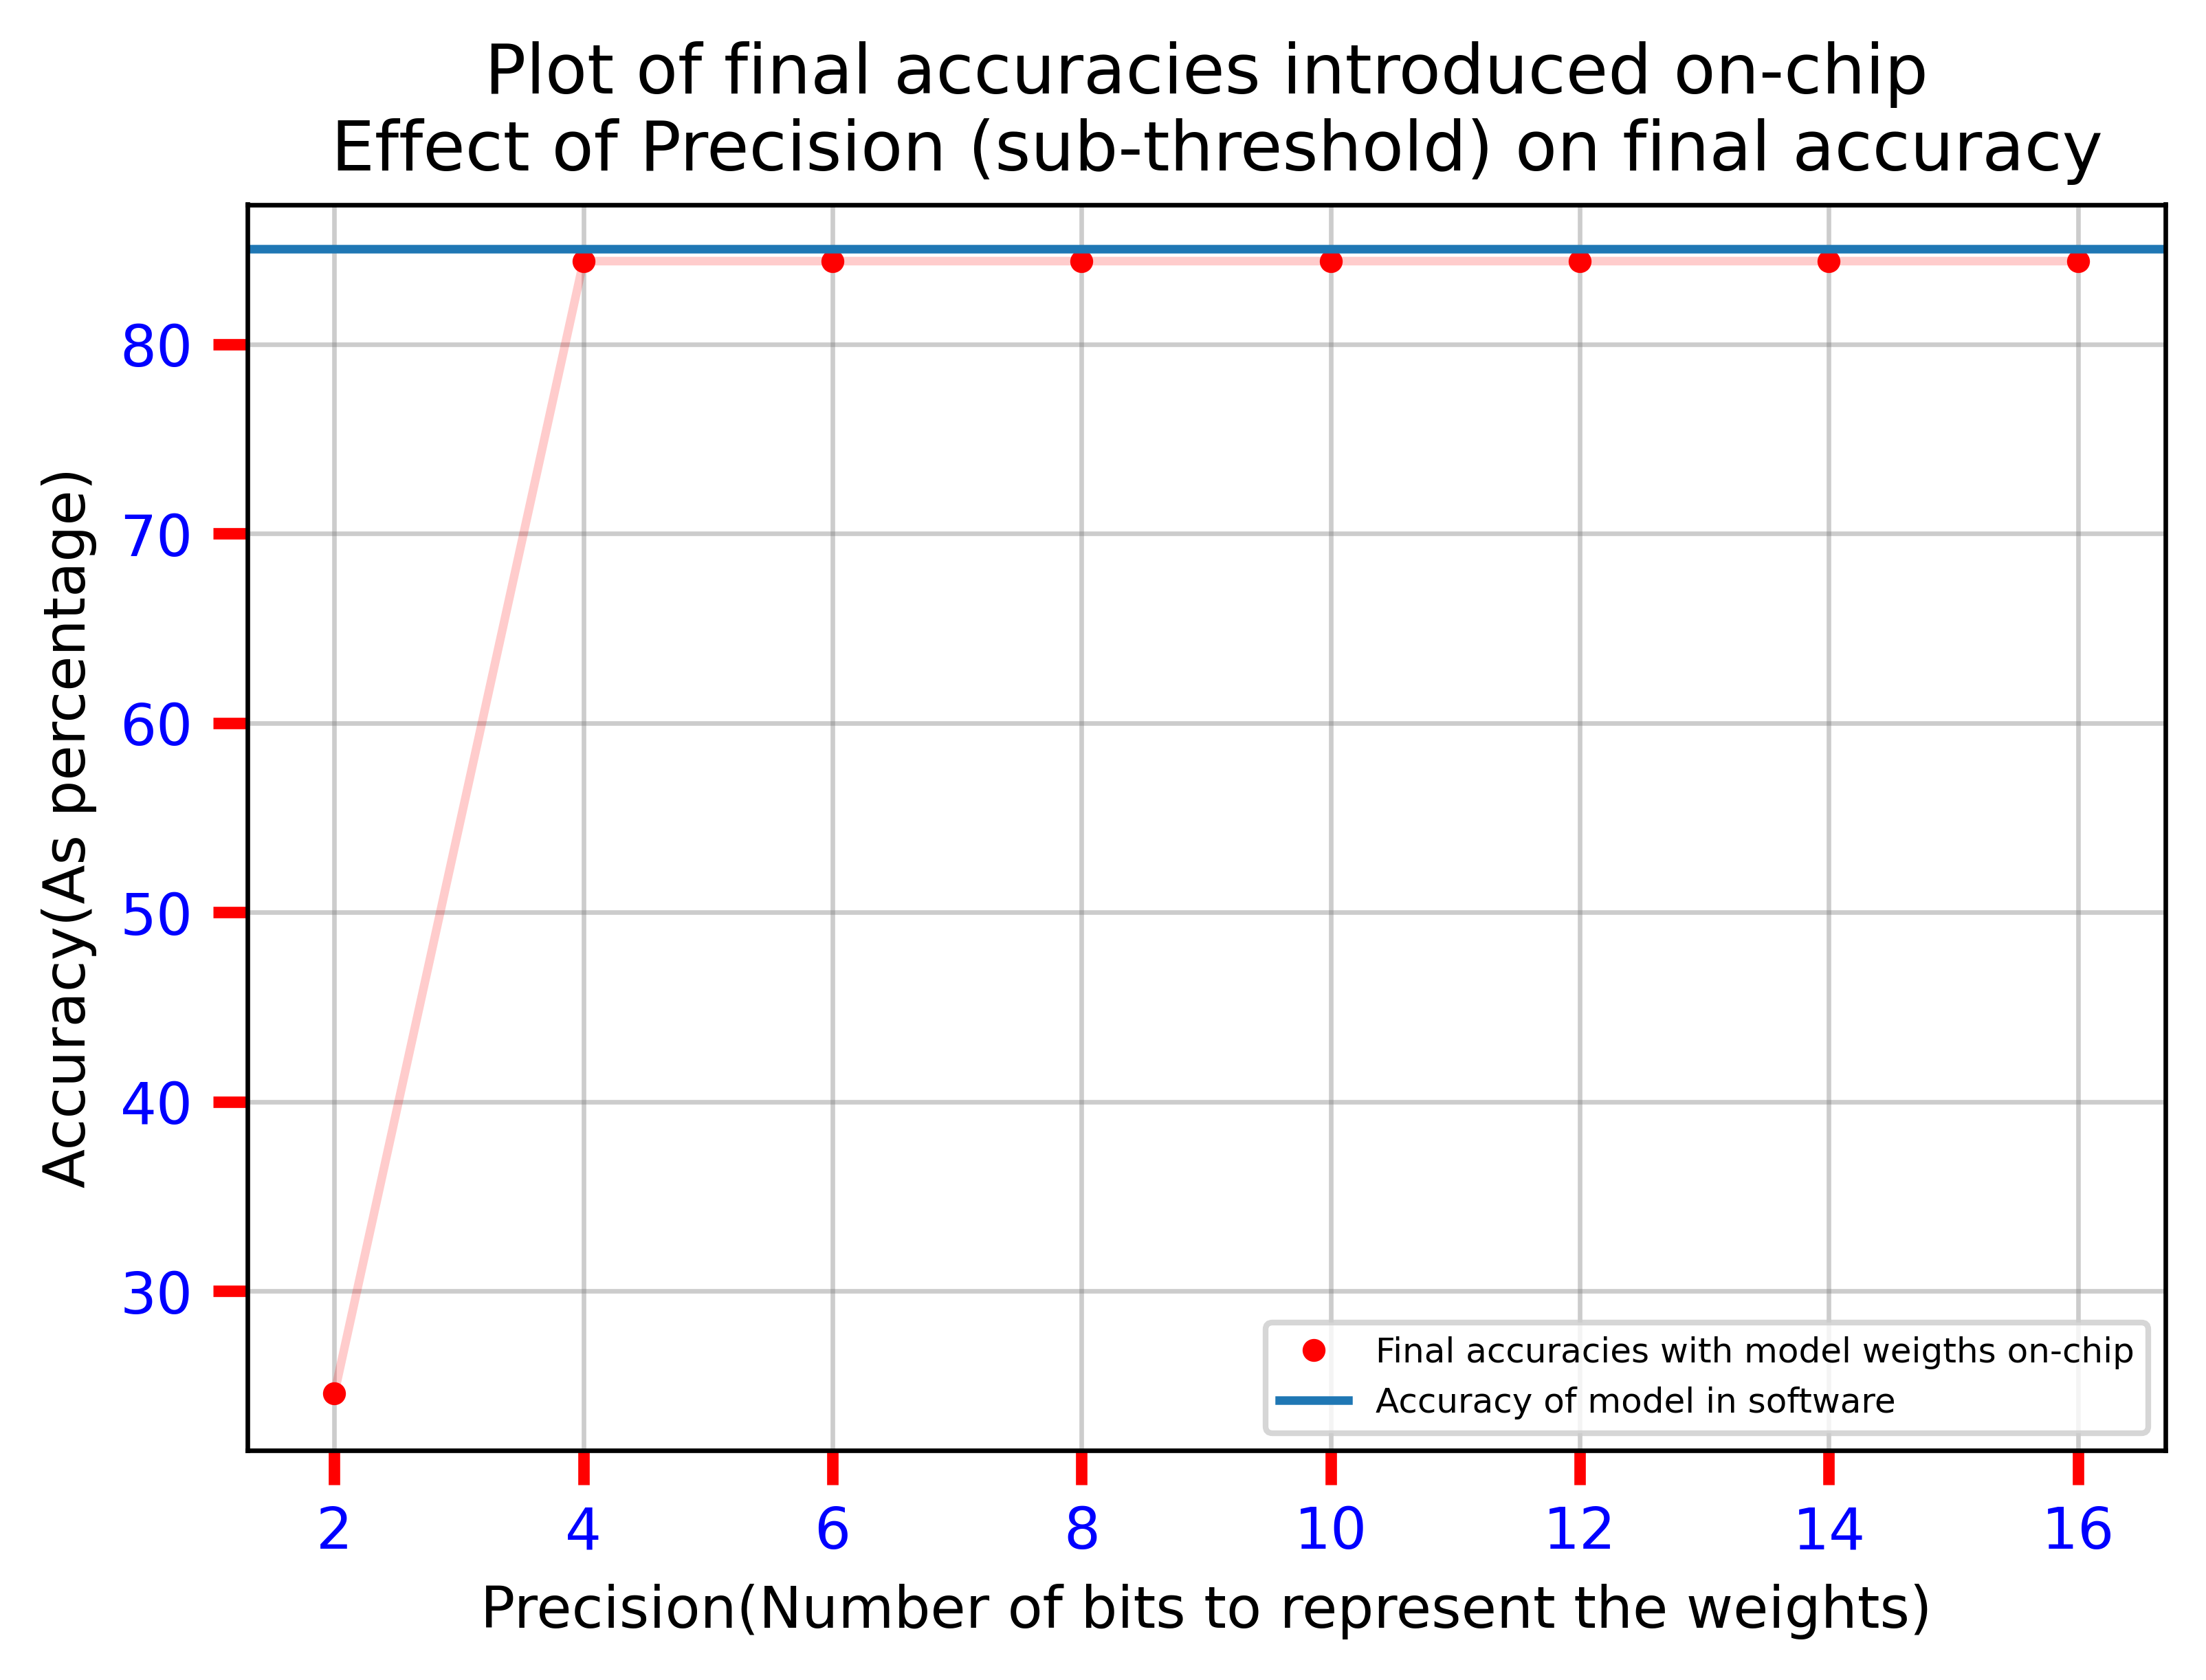

In [111]:
matplotlib.rcParams["figure.dpi"] = 600
plt.plot(precisionVal, onlineTrainAcc, 'r.', label = "Final accuracies with model weigths on-chip")
plt.plot(precisionVal, onlineTrainAcc, 'r', alpha = 0.2)
plt.axhline(train_accBP[-1], label = "Accuracy of model in software")
# plt.xscale("log")
plt.tick_params(axis='both', direction='out', length=6, width=2, labelcolor='b', colors='r', grid_color='gray', grid_alpha=0.4)
plt.grid()
plt.xlabel(r"Precision(Number of bits to represent the weights)")
plt.ylabel("Accuracy(As percentage)")
plt.title("Plot of final accuracies introduced on-chip\n Effect of Precision (sub-threshold) on final accuracy")
plt.legend(fontsize = 6)

# SNE demonstration

In [113]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123

In [112]:
def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([PathEffects.Stroke(linewidth=5, foreground="w"), PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts